загрузим данные из предварительно созданных dataset

In [113]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

Загружаем тренировочные и тестовые данные(можно было бы и валидационные, но зачем=) ?

In [114]:
device = "cuda" if torch.cuda.is_available() else "cpu"

train_set_x=torch.load(f="train_x.pt").to(device)
train_set_y=torch.load(f="train_y.pt").to(device)
train_set_z=torch.load(f="train_z.pt").to(device)

test_set_x=torch.load(f="test_x.pt").to(device)
test_set_y=torch.load(f="test_y.pt").to(device)
test_set_z=torch.load(f="test_z.pt").to(device)

подготовим нашу модель

In [115]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, y):
        input_data = torch.cat((x, y), dim=1)
        out = torch.relu(self.fc1(input_data))
        out = torch.relu(self.fc2(out))
        out = self.fc3(out)
        return out
net = Net().to(device)   
        

создадим функцию отрисовки трехмерного графика по нашим точкам(можно и просто графика... но мы же смотрим что будем предсказывать конкретно), а так же отрисуем апроксимированную функцию до обучения, просто на посмотреть и 

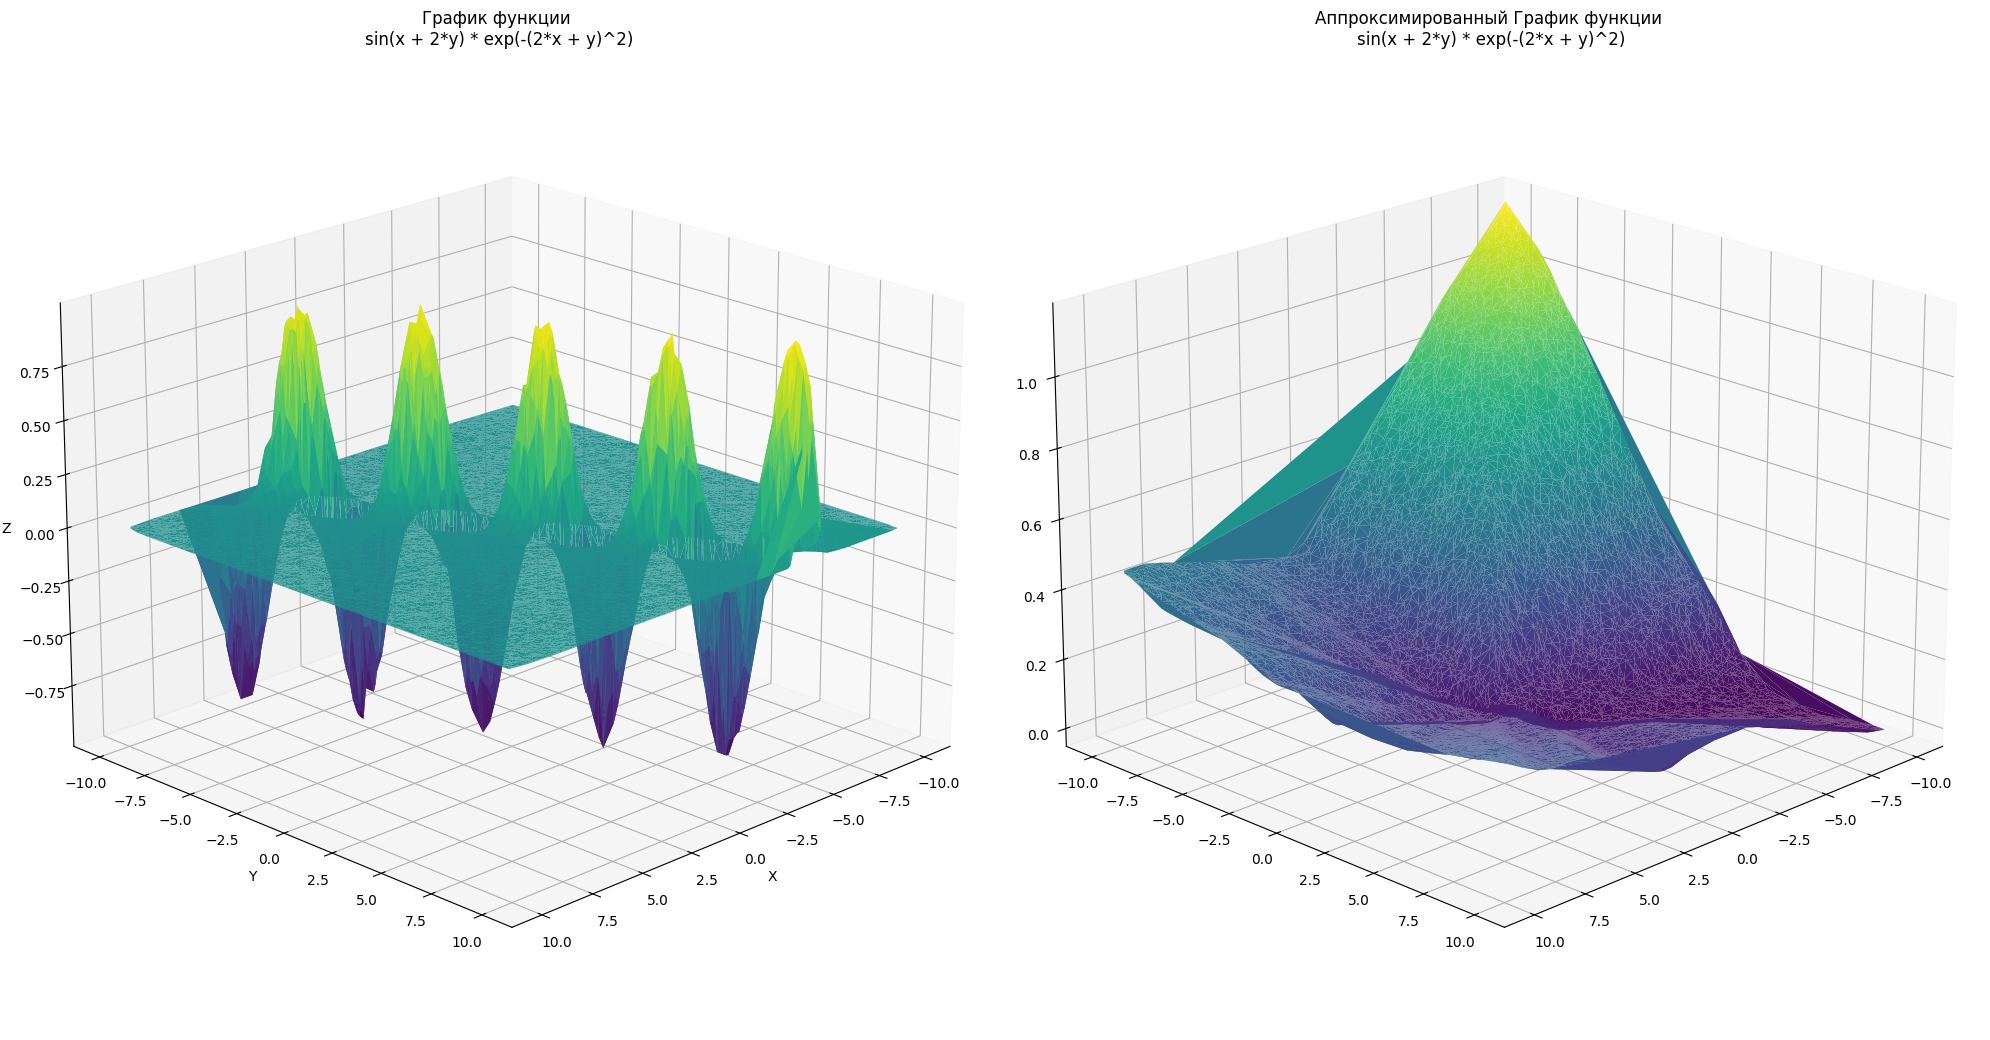

In [116]:
plt.rcParams ['figure.figsize'] = [20, 20]
def predict(net, x, y, z):
    fig, axs = plt.subplots(1, 2, subplot_kw={'projection': '3d'})
    fig.tight_layout(h_pad=5)
    Z = net(x,y)
    axs[0].set_xlabel('X')
    axs[0].set_ylabel('Y')
    axs[0].set_zlabel('Z')
    if torch.cuda.is_available(): 
        x_cpu=x.cpu().squeeze(1).numpy()
        y_cpu=y.cpu().squeeze(1).numpy()
        z_cpu=z.cpu().squeeze(1).numpy()
        Predict_cpu=Z.cpu().squeeze(1).detach().numpy()
        axs[1].plot_trisurf(x_cpu, y_cpu, Predict_cpu, cmap='viridis', label='Prediction')
        axs[0].plot_trisurf(x_cpu, y_cpu, z_cpu, cmap='viridis', label='Groud truth')
    else:
        axs[1].plot_surface(x.squeeze(1).numpy(), y.squeeze(1).numpy(), Z.squeeze(1).detach().numpy(), cmap='viridis', label='Prediction')
        axs[0].plot_surface(x.squeeze(1).numpy(), y.squeeze(1).numpy(), z.squeeze(1).numpy(), cmap='viridis', label='Groud truth')
    axs[0].set_title('График функции \nsin(x + 2*y) * exp(-(2*x + y)^2)')
    axs[1].set_title('Аппроксимированный График функции \nsin(x + 2*y) * exp(-(2*x + y)^2)')
    axs[0].view_init(elev=20, azim=45)
    axs[1].view_init(elev=20, azim=45)
predict(net, train_set_x, train_set_y,train_set_z)

зададим оптимизационный алгоритм и функцию потерь

In [117]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

обучим модель

In [118]:
epoch=0
while True:
    optimizer.zero_grad()
    outputs = net(train_set_x, train_set_y)
    loss = loss_fn(outputs, train_set_z)
    loss.backward()
    optimizer.step()
    if loss.item()<=0.0005:
        print(f'Last Epoch [{epoch + 1}], Loss: {loss.item():.4f}')
        break
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch + 1}], Loss: {loss.item():.4f}')
    epoch+=1


Epoch [1], Loss: 0.1322
Epoch [1001], Loss: 0.0107
Epoch [2001], Loss: 0.0049
Epoch [3001], Loss: 0.0047
Epoch [4001], Loss: 0.0014
Epoch [5001], Loss: 0.0011
Epoch [6001], Loss: 0.0009
Epoch [7001], Loss: 0.0008
Epoch [8001], Loss: 0.0006
Epoch [9001], Loss: 0.0009
Epoch [10001], Loss: 0.0005
Last Epoch [10177], Loss: 0.0005


по сути можно было уже после первой тысячи остановиться, но я решил получше обучиться и=) 

выведем loss на тесте, чтобы выплнить задание 3.a

In [119]:
net.eval()
with torch.no_grad():
    test_loss = 0
    outputs=net(test_set_x, test_set_y)
    test_loss = loss_fn(outputs, test_set_z).item()
print(f"Avg loss: {test_loss:>8f} \n")  


Avg loss: 0.000659 



еще раз нарисуем график, чтобы глазами увидеть как теперь красиво модель предсказывает данные(ну и заодно выполнить задание 3b)

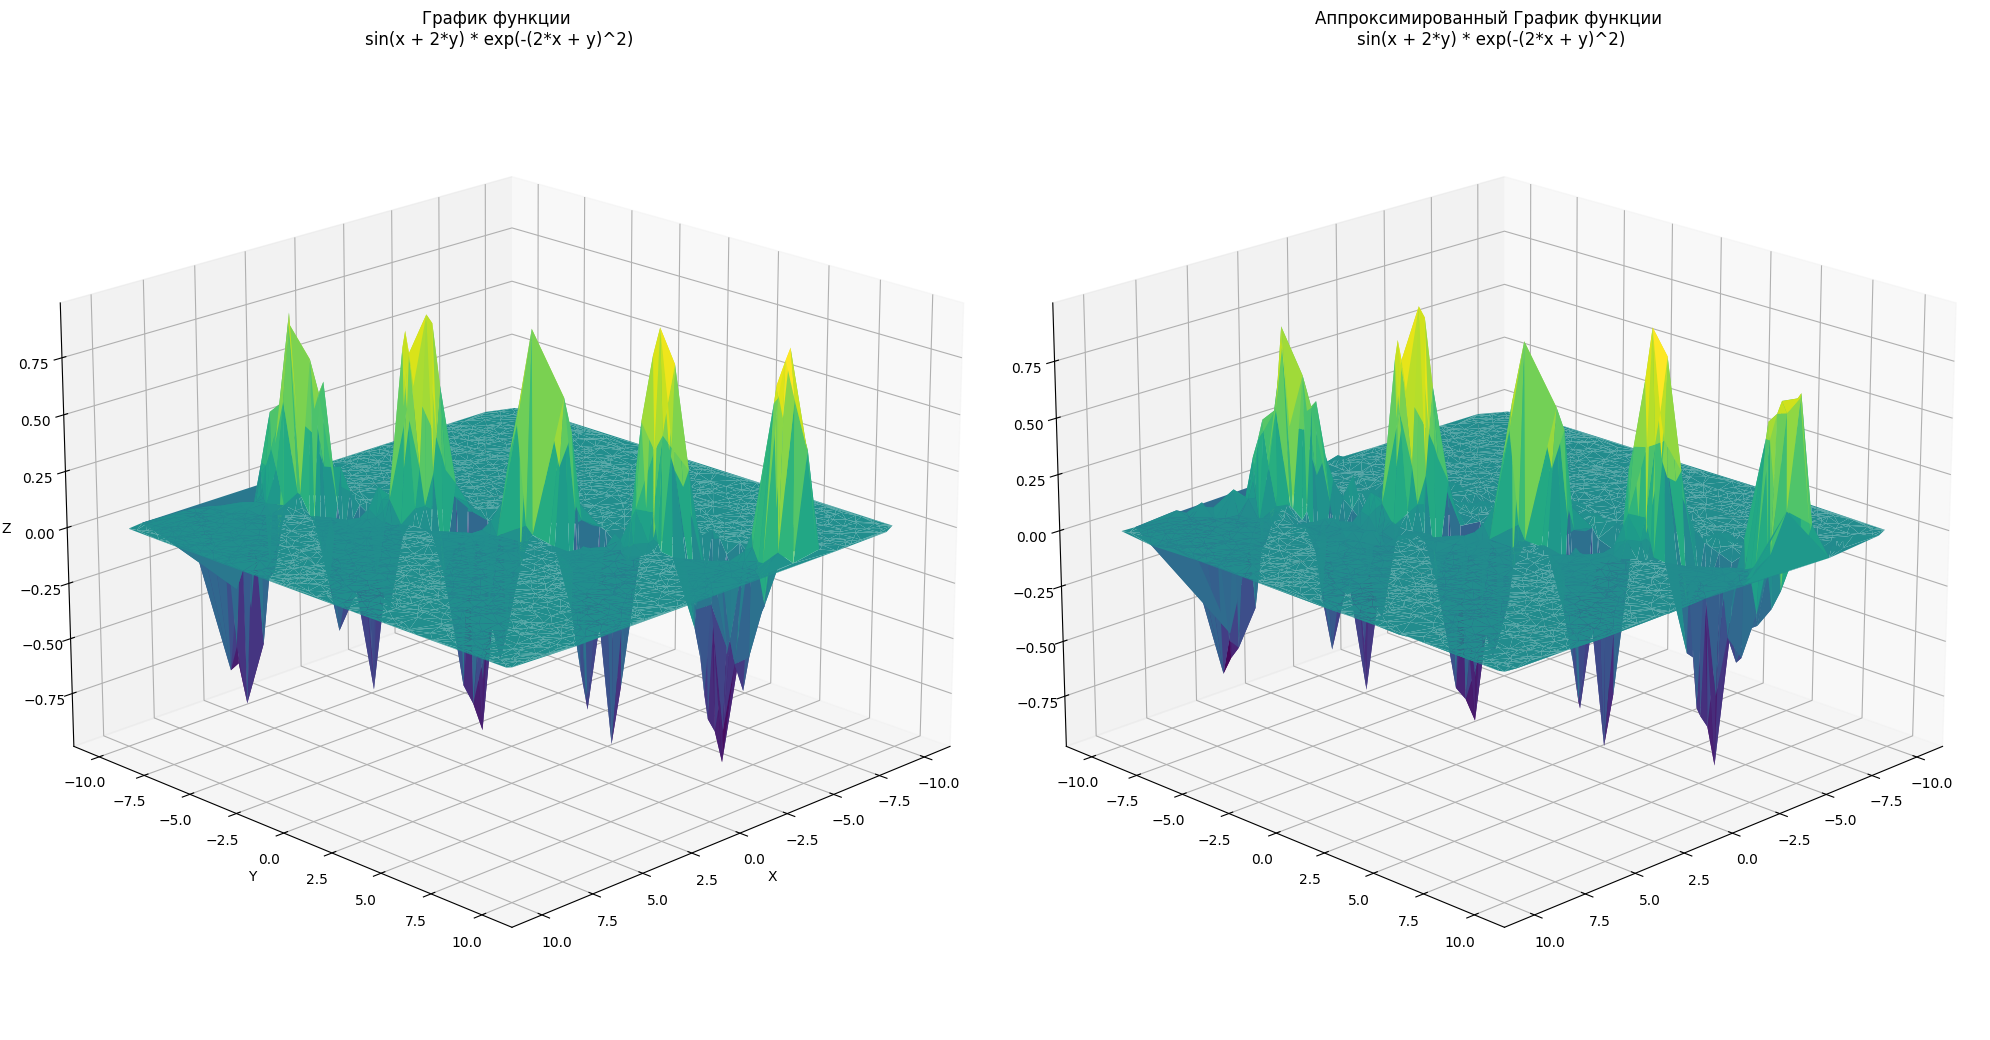

In [120]:
predict(net, test_set_x,test_set_y, test_set_z)